In [0]:
import sys
sys.path.append('../')

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from MaskedRNN import MaskedDeepLSTM

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
plt.rcParams.update({'font.size': 12})
sns.set_style('darkgrid')

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

#### Import, shuffle and split dataset

In [0]:
data = pd.read_csv('reber_sequences.csv')

In [0]:
data = data.sample(frac=1).reset_index(drop=True)

In [0]:
train_data = data[:int(.75*len(data))]
test_data = data[len(train_data):]

In [8]:
print('Total length: {}\nTrain data length: {}\nTest data length: {}'.format(len(data), len(train_data), len(test_data)))

Total length: 25000
Train data length: 18750
Test data length: 6250


#### Parameters

In [0]:
MODEL = 'lstm'

In [0]:
BATCH_SIZE = 16

INPUT_SIZE = 128
EMBEDDING_DIM = 100
OUTPUT_SIZE = 2

EPOCHS = 50
HIDDEN_LAYERS = [50, 50, 50]

#### Customize `Dataset`

In [0]:
class MakeDataset(Dataset):
    def __init__(self, data):
        self.strings = list(data['string'])
        self.valid = list(data['valid'])
        self.len = len(self.valid)
        self.valid_list = [0, 1]

    def __getitem__(self, index):
        return self.strings[index], self.valid[index]

    def __len__(self):
        return self.len

#### Train/Test Loader

In [0]:
dataset = MakeDataset(train_data)
train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

In [0]:
dataset = MakeDataset(test_data)
test_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

#### Helper functions

In [0]:
def create_variable(tensor):
    return Variable(tensor.to(device))

In [0]:
def pad_seq(vect_seqs, seq_lens, valid):
    seq_tensor = torch.zeros((len(vect_seqs), seq_lens.max())).long()
    
    for index, (seq, seq_len) in enumerate(zip(vect_seqs, seq_lens)):
        seq_tensor[index, :seq_len] = torch.LongTensor(seq)
        
    return create_variable(seq_tensor), create_variable(seq_lens), create_variable(valid)

In [0]:
def str2ascii(string):
    ascii_arr = [ord(s) for s in string]
    return ascii_arr, len(ascii_arr)

In [0]:
def make_variables(strings, valid):
    seqs_and_lens = [str2ascii(string)for string in strings]
    vect_seqs = [s[0] for s in seqs_and_lens]
    seq_lens = torch.LongTensor([s[1] for s in seqs_and_lens])
    valid = torch.LongTensor(valid)
    return pad_seq(vect_seqs, seq_lens, valid)

#### Model

In [0]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers: list):
        super(Model, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=hidden_layers[0]).to(device)
        self.recurrent = MaskedDeepLSTM(hidden_layers[0], hidden_layers).to(device)
        self.fc = nn.Linear(hidden_layers[-1], output_size).to(device)
        
    def forward(self, input):
        input = input.t()
        embedded = self.embedding(input)
        output = self.recurrent(embedded)
        return self.fc(output)

In [0]:
model = Model(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_LAYERS).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [20]:
print(model)

Model(
  (embedding): Embedding(128, 50)
  (recurrent): MaskedDeepLSTM(
    (recurrent_layers): ModuleList(
      (0): MaskedLSTMLayer(50, 50, mode=LSTM)
      (1): MaskedLSTMLayer(50, 50, mode=LSTM)
      (2): MaskedLSTMLayer(50, 50, mode=LSTM)
    )
  )
  (fc): Linear(in_features=50, out_features=2, bias=True)
)


#### Train & Test

In [0]:
def train():
    total_loss = 0
    
    for i, (string, valid) in enumerate(train_loader, 1):
        input, seq_lens, target = make_variables(string, valid)

        output = model(input)
        
        loss = criterion(output, target)
        total_loss += loss.data.item()
        
        model.zero_grad()
        loss.backward()
        optimizer.step()

In [0]:
test_acc = []

In [0]:
def test():
    correct = 0.
    test_data_size = len(test_loader.dataset)
    
    for string, valid in test_loader:
        input, seq_lens, target = make_variables(string, valid)

        output = model(input)

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    acc = 100 * correct / test_data_size
    test_acc.append(acc)

In [24]:
%%time
print('Epochs:', end=' ')
for epoch in range(1, EPOCHS+1):
    print('{}'.format(epoch), end=' ')
    train()
    test()
print('\n')

Epochs: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

CPU times: user 1h 42min 21s, sys: 9.14 s, total: 1h 42min 30s
Wall time: 1h 42min 53s


#### Plot & Save

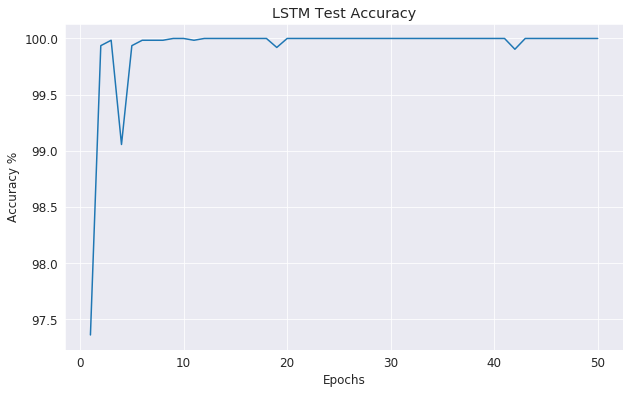

In [25]:
plt.figure(figsize=(10, 6))
plt.title('{} Test Accuracy'.format(MODEL.upper()))
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')
plt.savefig('./accuracies/{}-accuracy.png'.format(MODEL))
plt.plot(range(1, len(test_acc)+1), test_acc);

In [0]:
with open('./accuracies/{}-accuracies.txt'.format(MODEL), 'a') as f:
    f.write('{}'.format(MODEL.upper()) + ':' + ','.join(str(a.item()) for a in test_acc) + '\n')

In [0]:
torch.save(model.state_dict(), '{}-dict.pt'.format(MODEL))

#### Parameters Info

In [0]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

In [29]:
total_params, trainable_params = count_parameters(model)
print('Total parameters: {}\nTrainable parameters: {}'.format(total_params, trainable_params))

Total parameters: 67702
Trainable parameters: 67702


In [30]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print('{}: {}'.format(name, param.data.nelement()))

embedding.weight: 6400
recurrent.recurrent_layers.0.weight_ih: 10000
recurrent.recurrent_layers.0.weight_hh: 10000
recurrent.recurrent_layers.0.bias_ih: 200
recurrent.recurrent_layers.0.bias_hh: 200
recurrent.recurrent_layers.1.weight_ih: 10000
recurrent.recurrent_layers.1.weight_hh: 10000
recurrent.recurrent_layers.1.bias_ih: 200
recurrent.recurrent_layers.1.bias_hh: 200
recurrent.recurrent_layers.2.weight_ih: 10000
recurrent.recurrent_layers.2.weight_hh: 10000
recurrent.recurrent_layers.2.bias_ih: 200
recurrent.recurrent_layers.2.bias_hh: 200
fc.weight: 100
fc.bias: 2
